In [2]:
import os
import sys
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text
from scipy.stats import hypergeom
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multitest import multipletests

In [53]:
sys.path.append(os.path.abspath(".."))

# **Table merging**

- the latest [vdjdb](https://github.com/antigenomics/vdjdb-db) database was used for analysis
- the subset of TCR samples was merged based on V gene and cdr3 match

In [4]:
vdjdb = pd.read_csv("~/vdjdb-2025-02-21/vdjdb.txt", sep="\t", index_col=0)

In [5]:
rename_map = {
    "v.segm": "v_call",
    "j.segm": "j_call",
}
vdjdb.rename(
    columns={col: rename_map.get(col, col) for col in vdjdb.columns}, inplace=True
)

vdjdb["v_call"] = vdjdb["v_call"].str.replace(r"\*.*", "", regex=True)
vdjdb["j_call"] = vdjdb["j_call"].str.replace(r"\*.*", "", regex=True)
vdjdb["mhc.a"] = vdjdb["mhc.a"].str.replace(r"\*.*", "", regex=True)
vdjdb["mhc.b"] = vdjdb["mhc.b"].str.replace(r"\*.*", "", regex=True)

In [6]:
vdjdb.head()

,gene,cdr3,v_call,j_call,species,mhc.a,mhc.b,mhc.class,antigen.epitope,antigen.gene,antigen.species,reference.id,method,meta,cdr3fix,web.method,web.method.seq,web.cdr3fix.nc,web.cdr3fix.unmp,vdjdb.score
complex.id,,,,,,,,,,,,,,,,,,,,
0,TRB,CASSIVGGNEQFF,TRBV19,TRBJ2-1,HomoSapiens,HLA-A,B2M,MHCI,GILGFVFTL,M,InfluenzaA,PMID:28629751,"{""identification"": ""tetramer-sort "", ""frequenc...","{""study.id"": """", ""cell.subset"": ""CD8+"", ""subje...","{""cdr3"": ""CASSIVGGNEQFF"", ""cdr3_old"": ""CASSIVG...",sort,amplicon,no,no,2
0,TRB,CASSMRSTGELFF,TRBV19,TRBJ2-2,HomoSapiens,HLA-A,B2M,MHCI,GILGFVFTL,M,InfluenzaA,PMID:28629751,"{""identification"": ""tetramer-sort "", ""frequenc...","{""study.id"": """", ""cell.subset"": ""CD8+"", ""subje...","{""cdr3"": ""CASSMRSTGELFF"", ""cdr3_old"": ""CASSMRS...",sort,amplicon,no,no,2
0,TRB,CASSIRSAWAQYF,TRBV19,TRBJ2-3,HomoSapiens,HLA-A,B2M,MHCI,GILGFVFTL,M,InfluenzaA,PMID:28629751,"{""identification"": ""tetramer-sort "", ""frequenc...","{""study.id"": """", ""cell.subset"": ""CD8+"", ""subje...","{""cdr3"": ""CASSIRSAWAQYF"", ""cdr3_old"": ""CASSIRS...",sort,amplicon,no,no,2
0,TRB,CASSQRSTGELFF,TRBV19,TRBJ2-2,HomoSapiens,HLA-A,B2M,MHCI,GILGFVFTL,M,InfluenzaA,PMID:28629751,"{""identification"": ""tetramer-sort "", ""frequenc...","{""study.id"": """", ""cell.subset"": ""CD8+"", ""subje...","{""cdr3"": ""CASSQRSTGELFF"", ""cdr3_old"": ""CASSQRS...",sort,amplicon,no,no,3
0,TRB,CASSIRSSYEQYF,TRBV19,TRBJ2-7,HomoSapiens,HLA-A,B2M,MHCI,GILGFVFTL,M,InfluenzaA,PMID:28629751,"{""identification"": ""tetramer-sort "", ""frequenc...","{""study.id"": """", ""cell.subset"": ""CD8+"", ""subje...","{""cdr3"": ""CASSIRSSYEQYF"", ""cdr3_old"": ""CASSIRS...",sort,amplicon,no,no,3


In [7]:
airr_df = pd.read_csv("~/airr_tables/tcga_airr_compiled.txt", sep="\t")
metadata_df = pd.read_csv("~/airr_tables/tcga_metadata.tsv", sep="\t")

In [8]:
metadata_clean = metadata_df[["submitter_id", "project_id"]].drop_duplicates()
metadata_clean = metadata_clean.rename(columns={"submitter_id": "sample"})

In [9]:
airr_df_proj = airr_df.merge(metadata_clean, on="sample", how="left")

In [10]:
TCR = airr_df_proj[
    airr_df_proj.locus.apply(lambda x: x in {"TRA", "TRB", "TRD", "TRG"})
]

In [16]:
TCR.rename(columns={"junction_aa": "cdr3"}, inplace=True)

- Merge with 1 acceptable mismatch of cdr3 sequence.

In [12]:
def generate_masks_with_gene(seq: str, gene: str) -> set[str]:
    masks = {f"{gene}-{seq}"}
    for i in range(len(seq)):
        masks.add(f"{gene}-{seq[:i]}X{seq[i+1:]}")
    return masks


def build_mask_dict(tcr_df: pd.DataFrame) -> dict[str, list[int]]:
    mask_dict = defaultdict(list)
    for idx, row in tcr_df.iterrows():
        for m in generate_masks_with_gene(row.cdr3, row.v_call):
            mask_dict[m].append(idx)
    return mask_dict


TCR = TCR.dropna(subset=["cdr3", "v_call"]).reset_index(drop=True)
vdjdb = vdjdb.dropna(subset=["cdr3", "v_call"]).reset_index(drop=True)

mask_dict = build_mask_dict(TCR)


pairs = []

for j, row in vdjdb.iterrows():
    gene, seq = row.v_call, row.cdr3
    vdj_masks = generate_masks_with_gene(seq, gene)

    tcr_hits = set()
    for m in vdj_masks:
        tcr_hits.update(mask_dict.get(m, []))

    exact_mask = f"{gene}-{seq}"
    for i in tcr_hits:
        mism = 0 if i in mask_dict[exact_mask] else 1
        pairs.append((i, j, mism))

merged = (
    pd.DataFrame(pairs, columns=["tcr_idx", "vdj_idx", "mismatches"])
    .merge(TCR.add_prefix("tcr_"), left_on="tcr_idx", right_index=True)
    .merge(vdjdb.add_prefix("vdj_"), left_on="vdj_idx", right_index=True)
    .drop(columns=["tcr_idx", "vdj_idx"])
)

- Renaming the same genes with different names:

In [13]:
gene_synonyms = {
    "MART1": "MLANA",
    "Gag": "GAG",
    "Pol": "POL",
    "gp160": "GP160",
    "Nef": "NEF",
    "Vpr": "VPR",
    "IE-1": "IE1",
    "synthetic": "Synthetic",
    "M1-F5L": "M1",
    "M1-G4E": "M1",
    "P3C": "P3A",
    "GAD65": "GAD2",
    "MAGE-A1": "MAGEA1",
    "MAGE-A2": "MAGEA2",
    "HER2": "ERBB2",
    "MLL2": "KMT2D",
    "5T4": "TPBG",
    "gp100": "PMEL",
    "p53": "TP53",
}

merged["vdj_antigen.gene"] = merged["vdj_antigen.gene"].replace(gene_synonyms)

- Subset without mismatches in cdr3 sequence

In [14]:
strict_merged = merged[merged["mismatches"] == 0]

# **Fisher test**

- hitmaps of Fisher test odds ratio of receptors to specific antigenes abundance in samples of each TCGA project vs. other TCGA projects

In [15]:
from scripts.vdjdb_functions import fisher_by_sample, analyse_locus

- For human antigens only:

In [43]:
hs_df = strict_merged[strict_merged["vdj_antigen.species"] == "HomoSapiens"]
genes = hs_df["vdj_antigen.gene"].unique()
genes = pd.Series(genes).dropna().unique()

In [49]:
merged_results = []

for gene in genes:
    res = fisher_by_sample(hs_df, gene)
    if not res.empty:
        merged_results.append(res)

all_results = pd.concat(merged_results, ignore_index=True)

In [50]:
all_results["log2_or"] = np.log2(all_results["odds_ratio"].replace(0, np.nan))
all_results["log10_p"] = -np.log10(all_results["p_value_adj"].replace(0, np.nan))

In [51]:
heatmap_data = all_results.pivot_table(
    index="gene", columns="project_id", values="log2_or", fill_value=0
)

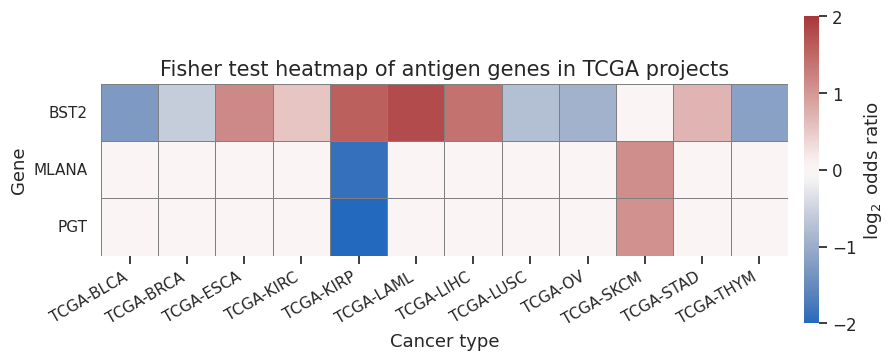

In [56]:
n_genes = heatmap_data.shape[0]
n_projects = heatmap_data.shape[1]

plt.figure(figsize=(n_projects * 0.6 + 2, n_genes * 0.6 + 2))

ax = sns.heatmap(
    heatmap_data,
    cmap="vlag",
    center=0,
    vmin=-2,
    vmax=2,
    square=True,
    linewidths=0.7,
    linecolor="gray",
    cbar_kws={
        "label": r"$\log_2$ odds ratio",
        "ticks": [-2, -1, 0, 1, 2],
        "fraction": 0.1,
        "pad": 0.02,
    },
)

ax.tick_params(axis="x", which="both", top=False, bottom=True, length=6)

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right", fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)

ax.set_xlabel("Cancer type", fontsize=13)
ax.set_ylabel("Gene", fontsize=13)
ax.set_title("Fisher test heatmap of antigen genes in TCGA projects", fontsize=15)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

- For all antigens:

In [64]:
all_merged_results = []

for gene in strict_merged["vdj_antigen.gene"].dropna().unique():
    res = fisher_by_sample(strict_merged, gene)
    if not res.empty:
        all_merged_results.append(res)

all_all_results = pd.concat(all_merged_results, ignore_index=True)

In [65]:
all_all_results["log2_or"] = np.log2(all_all_results["odds_ratio"].replace(0, np.nan))
all_all_results["log10_p"] = -np.log10(
    all_all_results["p_value_adj"].replace(0, np.nan)
)

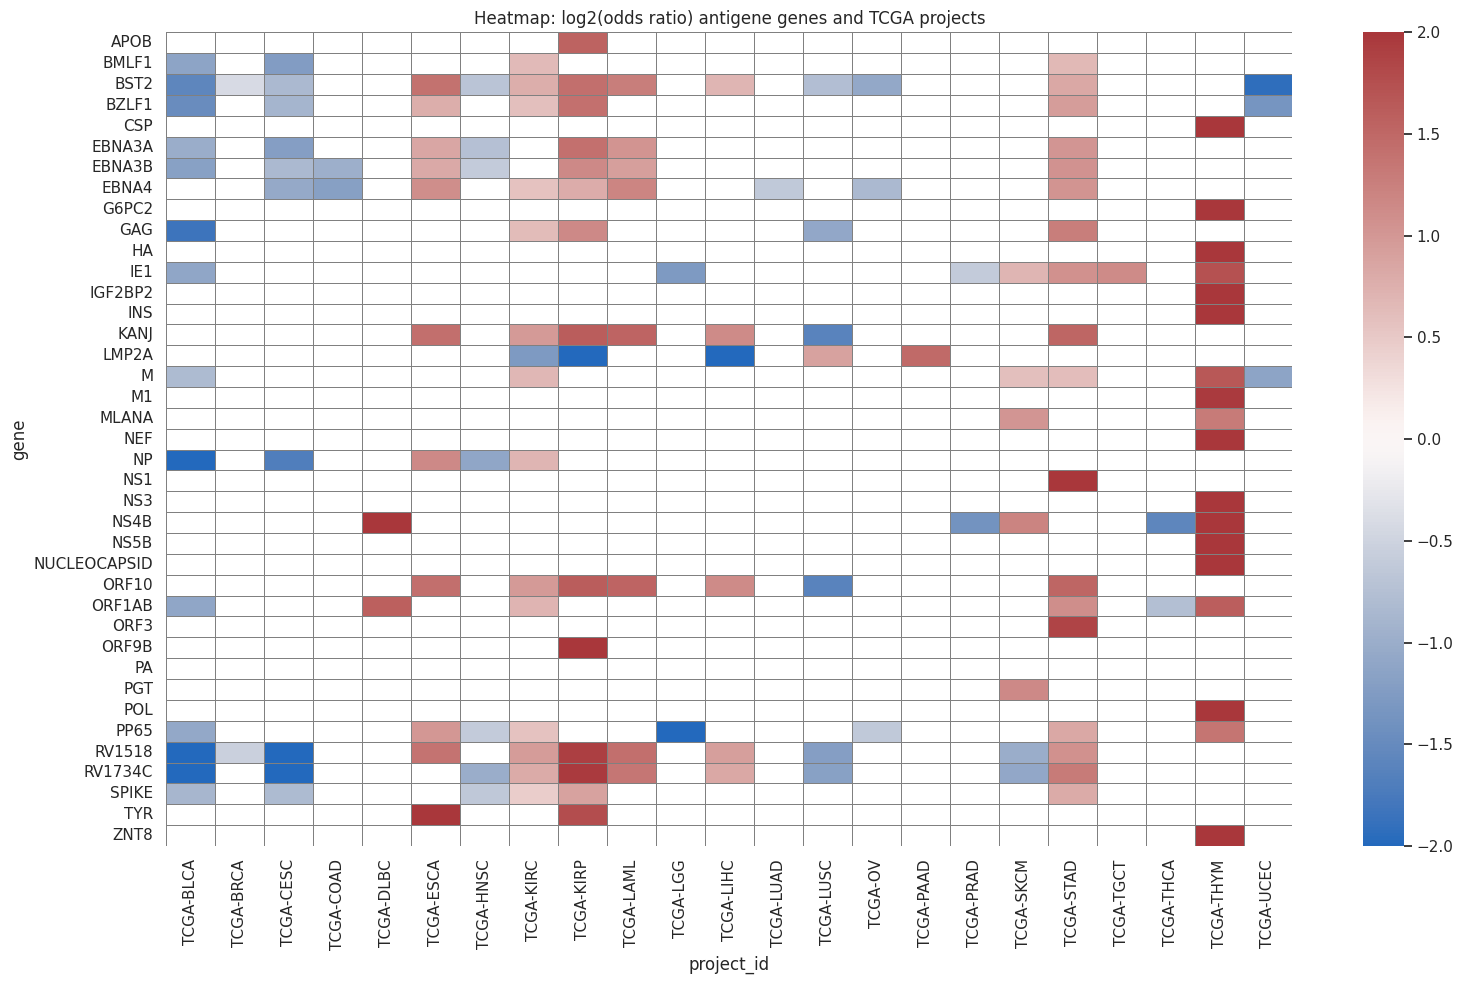

In [70]:
heatmap_data = all_all_results.pivot_table(
    index="gene", columns="project_id", values="log2_or"
)

plt.figure(figsize=(16, 10))
sns.set(style="white")
sns.heatmap(
    heatmap_data,
    cmap="vlag",
    center=0,
    vmin=-2,
    vmax=2,
    linewidths=0.5,
    linecolor="gray",
)
plt.title("Heatmap: log2(odds ratio) antigene genes and TCGA projects")
plt.tight_layout()
plt.show()

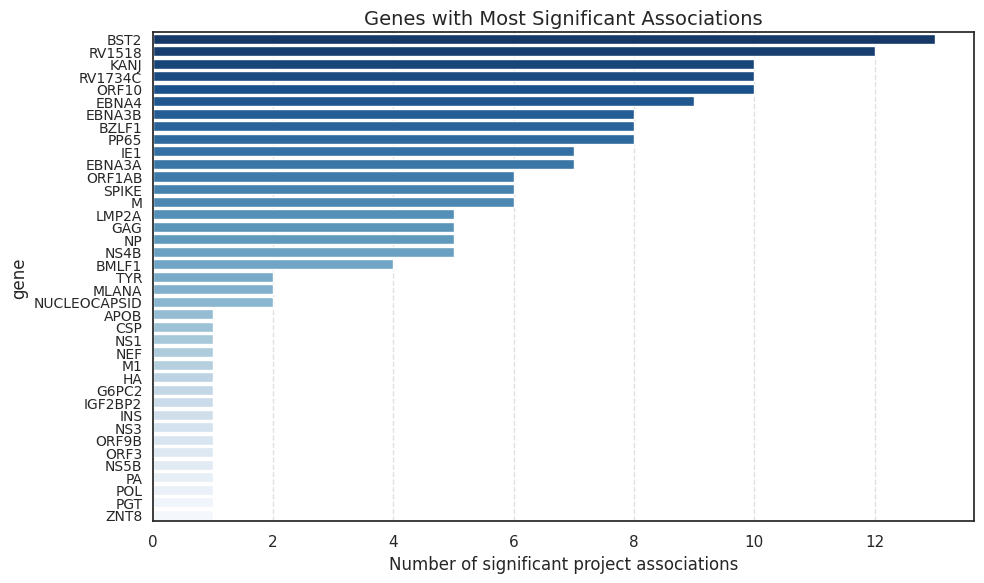

In [73]:
sig_counts = all_all_results.groupby("gene").size().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y=sig_counts.index, x=sig_counts.values, palette="Blues_r")

plt.xlabel("Number of significant project associations", fontsize=12)
plt.title("Genes with Most Significant Associations", fontsize=14)

plt.yticks(fontsize=10)
plt.tick_params(axis="y", which="major", length=4)

plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# **Epitope–Project Overlap Analysis**

This analysis estimates whether specific epitopes are over- or under-represented in different cancer types (projects), based on TCR CDR3 sequences.

The steps are as follows:

- For each project, compute the number of **unique CDR3 sequences**.
- For each epitope, compute the number of **unique CDR3 sequences** associated with it.
- For each epitope–project pair, calculate the **observed overlap**: the number of CDR3 sequences shared by both the project and the epitope.
- Calculate the **expected overlap** using a multiplicative model:
  
Expected overlap = mean weighted duplicate count per sample in project \ times total weighted duplicate count of epitope


  > *Weighted duplicate count* distributes each TCR clone’s count across all epitopes it is associated with.

- Fit a **linear regression** (no intercept) between expected and observed overlap.
- Visualize the results as a **scatter plot**:
  - X-axis: expected overlap
  - Y-axis: observed overlap
  - The diagonal line shows the model prediction.
  - Residuals indicate over-/under-representation of epitopes in each project.

Only epitopes with:
- at least **30 unique CDR3 sequences**, and
- total clone count between **100 and 150**

are included in the analysis.


## Results for dataframe with mismatches:

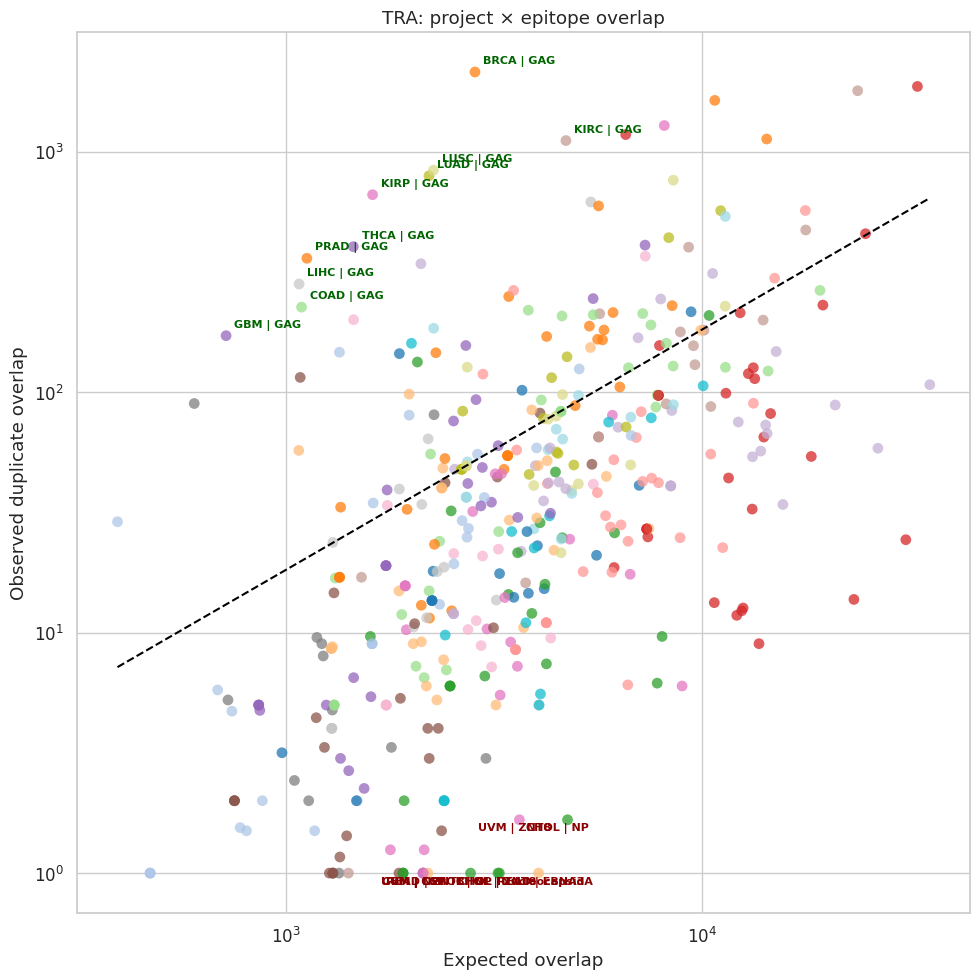

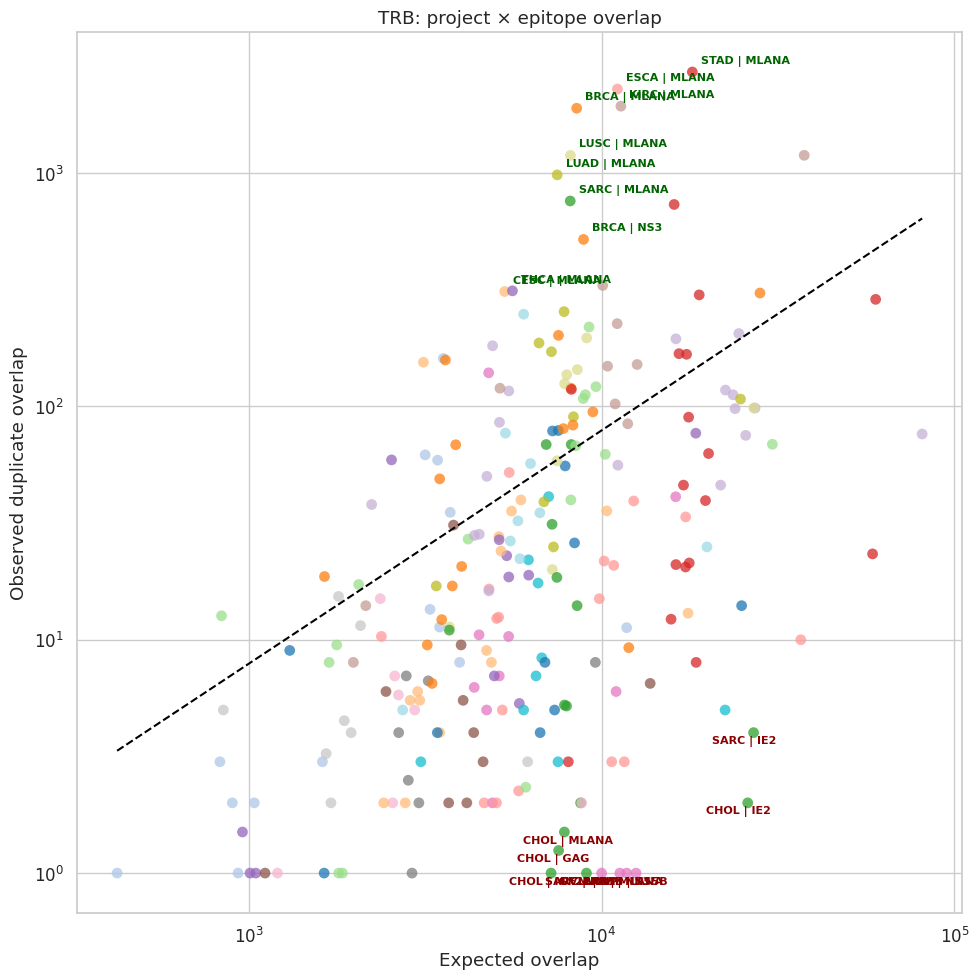

In [23]:
results_mis = {}
for locus in ["TRA", "TRB"]:
    df_loc = merged.loc[merged["tcr_locus"] == locus].copy()
    results_mis[locus] = analyse_locus(df_loc, locus)

- Top antigen genes with biggest positive and negative residuals:

In [25]:
cols = ["project_id", "epitope", "antigen_species", "antigen_gene", "residual"]

df_tra = results_mis["TRA"].copy()

top_pos_TRA = (
    df_tra[df_tra["residual"] > 0]
    .sort_values("residual", ascending=False)
    .head(5)[cols]
)
top_neg_TRA = df_tra[df_tra["residual"] < 0].sort_values("residual").head(5)[cols]

df_trb = results_mis["TRB"].copy()

top_pos_TRB = (
    df_trb[df_trb["residual"] > 0]
    .sort_values("residual", ascending=False)
    .head(5)[cols]
)
top_neg_TRB = df_trb[df_trb["residual"] < 0].sort_values("residual").head(5)[cols]

In [26]:
top_pos_TRA

,project_id,epitope,antigen_species,antigen_gene,residual
365,BRCA,RTLNAWVKV,HIV-1,GAG,1.616829
375,KIRP,RTLNAWVKV,HIV-1,GAG,1.352379
380,LUSC,RTLNAWVKV,HIV-1,GAG,1.308104
379,LUAD,RTLNAWVKV,HIV-1,GAG,1.295396
385,PRAD,RTLNAWVKV,HIV-1,GAG,1.245632


In [27]:
top_pos_TRB

,project_id,epitope,antigen_species,antigen_gene,residual
2,BRCA,ALAGIGILTV,HomoSapiens,MLANA,1.451445
7,ESCA,ALAGIGILTV,HomoSapiens,MLANA,1.418166
11,KIRC,ALAGIGILTV,HomoSapiens,MLANA,1.334925
26,STAD,ALAGIGILTV,HomoSapiens,MLANA,1.279005
17,LUSC,ALAGIGILTV,HomoSapiens,MLANA,1.266879


## Results for dataframe with mismatches with only human antigens:

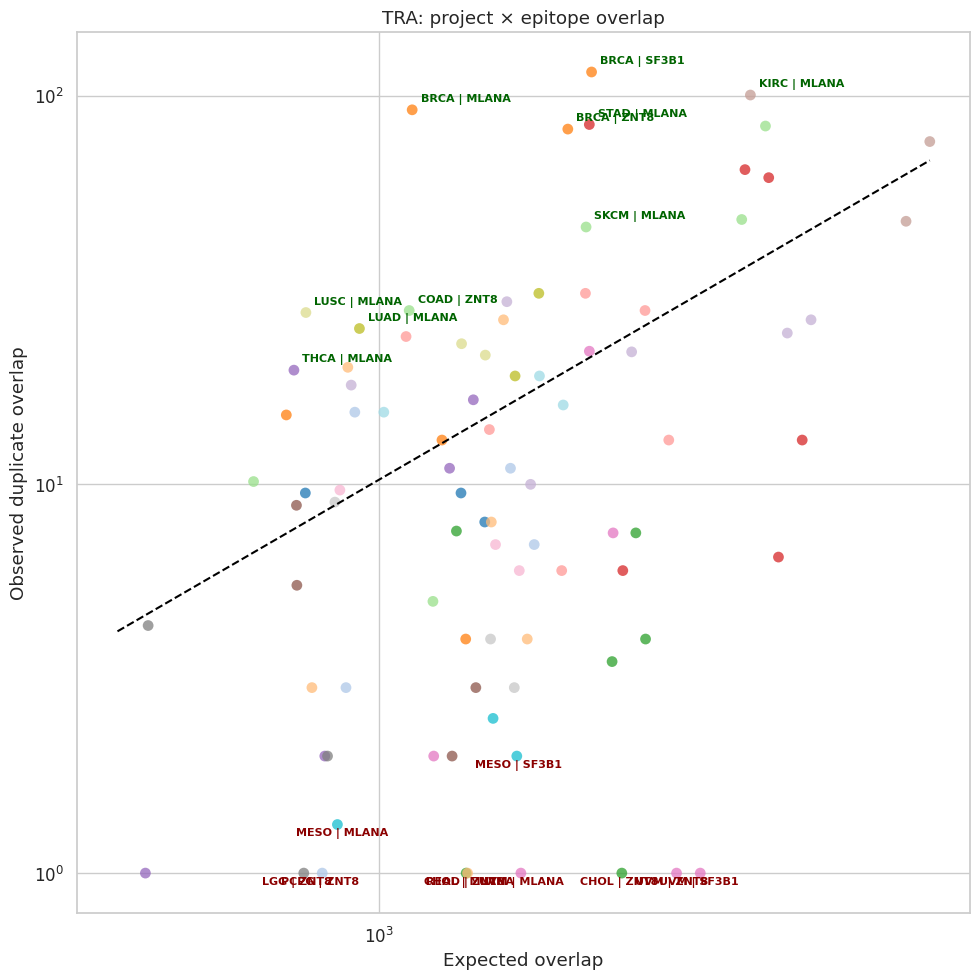

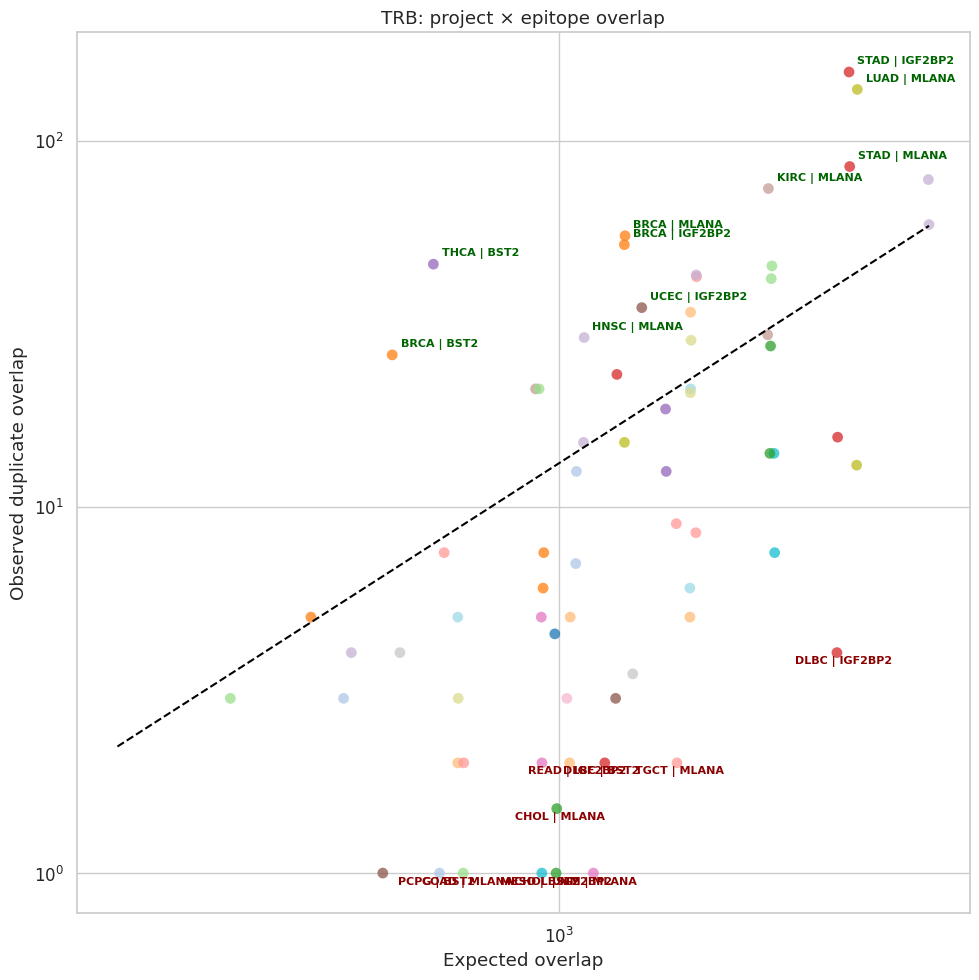

In [28]:
results_hs = {}
for locus in ["TRA", "TRB"]:
    df_loc = merged.loc[merged["tcr_locus"] == locus].copy()
    df_loc_hs = df_loc.loc[df_loc["vdj_antigen.species"] == "HomoSapiens"].copy()
    results_hs[locus] = analyse_locus(df_loc_hs, locus)

- Top antigen genes with biggest positive and negative residuals:

In [29]:
df_tra_hs = results_hs["TRA"].copy()

top_pos_TRA_hs = (
    df_tra_hs[df_tra_hs["residual"] > 0]
    .sort_values("residual", ascending=False)
    .head(5)[cols]
)
top_neg_TRA_hs = (
    df_tra_hs[df_tra_hs["residual"] < 0].sort_values("residual").head(5)[cols]
)

df_trb_hs = results_hs["TRB"].copy()

top_pos_TRB_hs = (
    df_trb_hs[df_trb_hs["residual"] > 0]
    .sort_values("residual", ascending=False)
    .head(5)[cols]
)
top_neg_TRB_hs = (
    df_trb_hs[df_trb_hs["residual"] < 0].sort_values("residual").head(5)[cols]
)

In [30]:
top_pos_TRA_hs

,project_id,epitope,antigen_species,antigen_gene,residual
2,BRCA,ALGIGILTV,HomoSapiens,MLANA,0.902037
35,BRCA,RLPGVLPRA,HomoSapiens,SF3B1,0.731810
68,BRCA,YAYAKWKL,HomoSapiens,ZNT8,0.620337
26,STAD,ALGIGILTV,HomoSapiens,MLANA,0.600025
17,LUSC,ALGIGILTV,HomoSapiens,MLANA,0.539066


In [31]:
top_pos_TRB_hs

,project_id,epitope,antigen_species,antigen_gene,residual
61,THCA,LLLGIGILV,HomoSapiens,BST2,0.763607
35,BRCA,LLLGIGILV,HomoSapiens,BST2,0.587956
92,STAD,NLSALGIFST,HomoSapiens,IGF2BP2,0.560182
2,BRCA,ALAGIGILTV,HomoSapiens,MLANA,0.505448
16,LUAD,ALAGIGILTV,HomoSapiens,MLANA,0.498089


## Results for dataframe without mismatches:

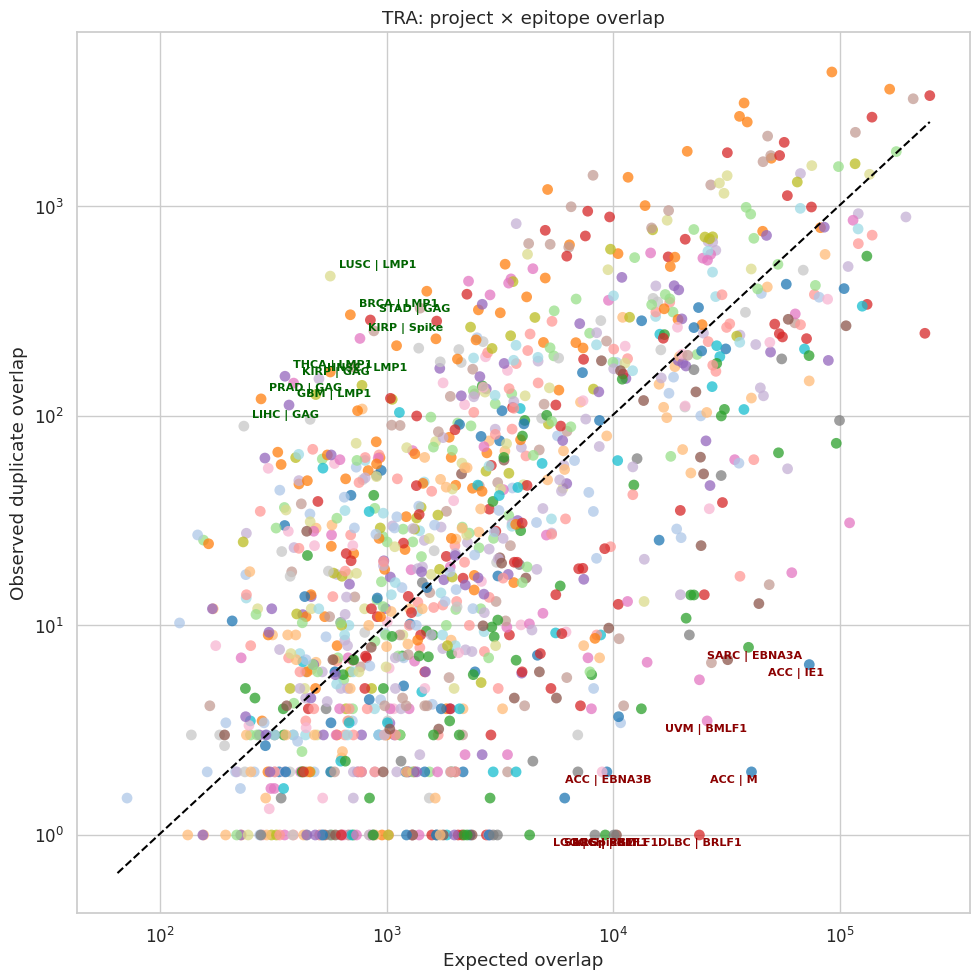

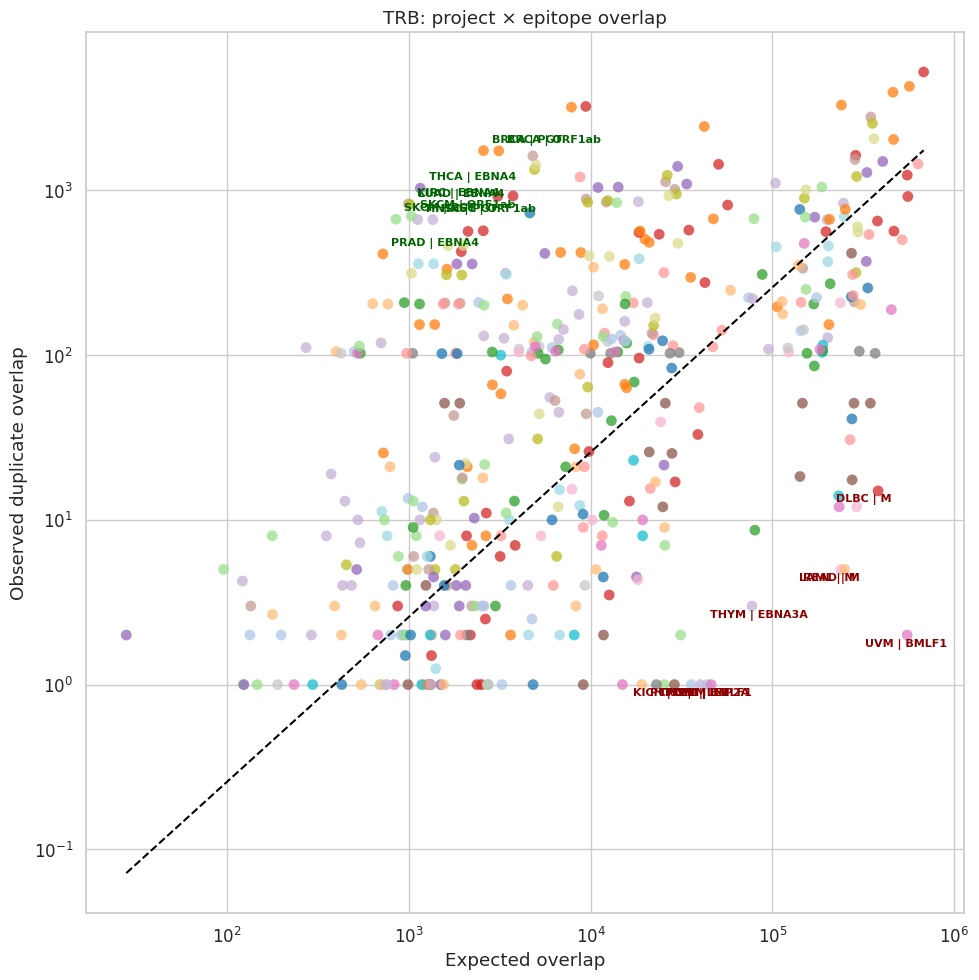

In [20]:
results_str = {}
for locus in ["TRA", "TRB"]:
    df_loc = strict_merged.loc[strict_merged["tcr_locus"] == locus].copy()
    results_str[locus] = analyse_locus(
        df_loc, locus, min_cdr3_per_epitope=5, epitope_size_range=(10, 5000)
    )

In [32]:
df_tra_str = results_str["TRA"].copy()

top_pos_TRA_str = (
    df_tra_str[df_tra_str["residual"] > 0]
    .sort_values("residual", ascending=False)
    .head(5)[cols]
)
top_neg_TRA_str = (
    df_tra_str[df_tra_str["residual"] < 0].sort_values("residual").head(5)[cols]
)

df_trb_str = results_str["TRB"].copy()

top_pos_TRB_str = (
    df_trb_str[df_trb_str["residual"] > 0]
    .sort_values("residual", ascending=False)
    .head(5)[cols]
)
top_neg_TRB_str = (
    df_trb_str[df_trb_str["residual"] < 0].sort_values("residual").head(5)[cols]
)

In [33]:
top_pos_TRA_str

,project_id,epitope,antigen_species,antigen_gene,residual
1436,LUSC,YLLEMLWRL,EBV,LMP1,1.909240
1421,BRCA,YLLEMLWRL,EBV,LMP1,1.636247
1447,THCA,YLLEMLWRL,EBV,LMP1,1.631204
1177,PRAD,SLFNTVATLY,HIV-1,GAG,1.628803
1170,LIHC,SLFNTVATLY,HIV-1,GAG,1.574797


In [34]:
top_pos_TRB_str

,project_id,epitope,antigen_species,antigen_gene,residual
226,THCA,IVTDFSVIK,EBV,EBNA4,2.539851
209,KIRC,IVTDFSVIK,EBV,EBNA4,2.510333
214,LUAD,IVTDFSVIK,EBV,EBNA4,2.498172
322,SKCM,LLAGIGTVPI,HomoSapiens,PGT,2.485253
685,SKCM,TTDPSFLGRY,SARS-CoV-2,ORF1ab,2.420356


## Results for dataframe without mismatches with only human antigens:

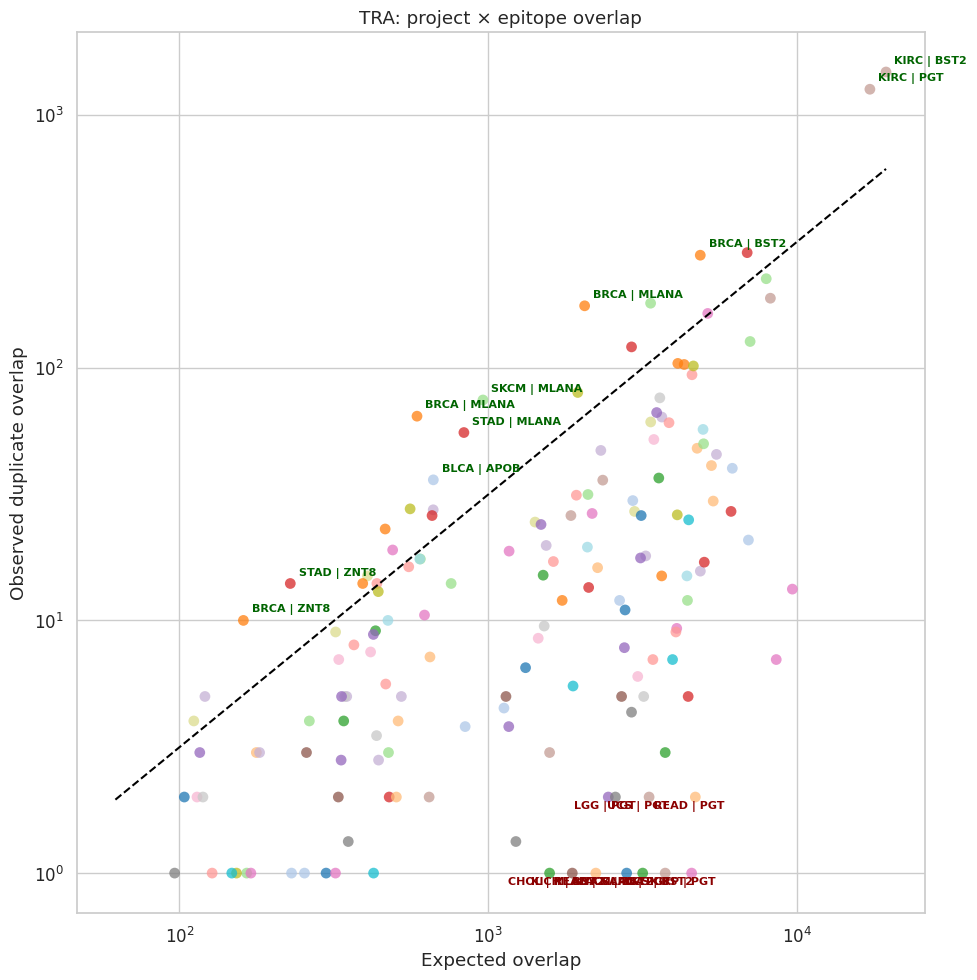

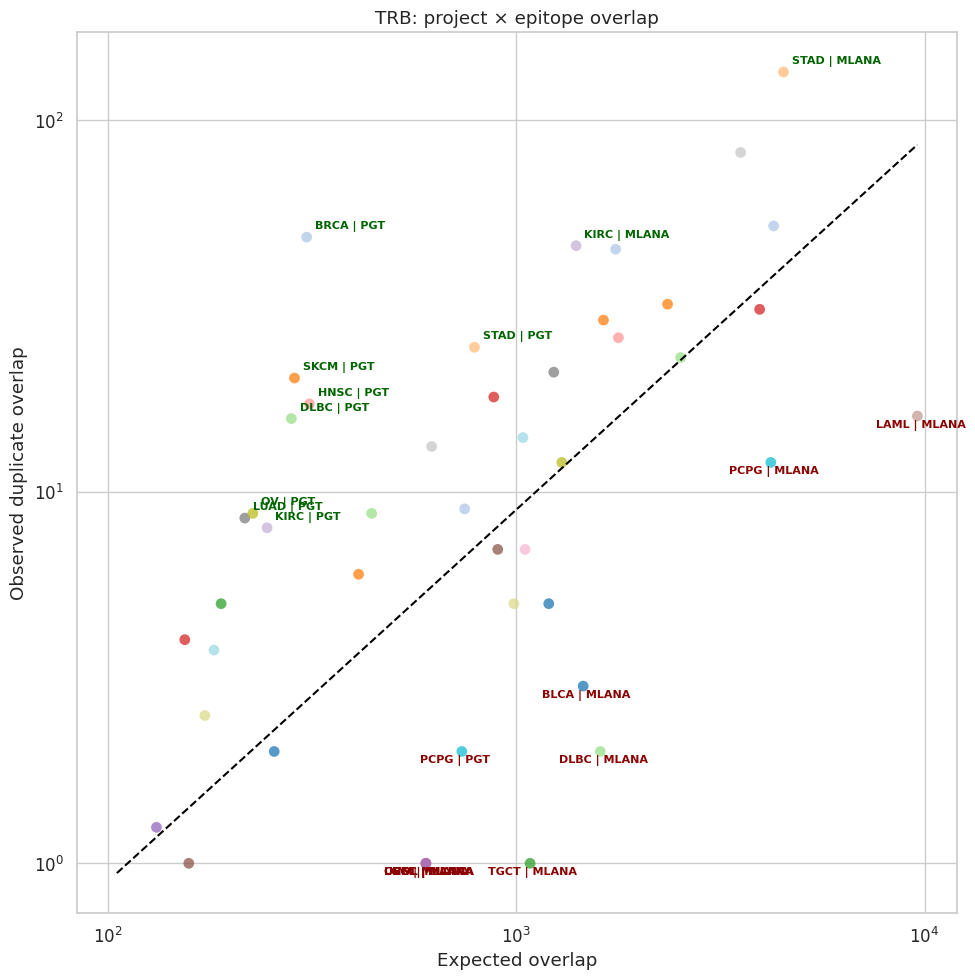

In [39]:
strict_merged_homo = strict_merged.loc[
    strict_merged["vdj_antigen.species"] == "HomoSapiens"
]
results_str_hs = {}
for locus in ["TRA", "TRB"]:
    df_loc = strict_merged_homo.loc[strict_merged_homo["tcr_locus"] == locus].copy()
    results_str_hs[locus] = analyse_locus(
        df_loc, locus, min_cdr3_per_epitope=5, epitope_size_range=(10, 5000)
    )

In [40]:
df_tra_str_hs = results_str_hs["TRA"].copy()

top_pos_TRA_str_hs = (
    df_tra_str_hs[df_tra_str_hs["residual"] > 0]
    .sort_values("residual", ascending=False)
    .head(5)[cols]
)
top_neg_TRA_str_hs = (
    df_tra_str_hs[df_tra_str_hs["residual"] < 0].sort_values("residual").head(5)[cols]
)

df_trb_str_hs = results_str_hs["TRB"].copy()

top_pos_TRB_str_hs = (
    df_trb_str_hs[df_trb_str_hs["residual"] > 0]
    .sort_values("residual", ascending=False)
    .head(5)[cols]
)
top_neg_TRB_str_hs = (
    df_trb_str_hs[df_trb_str_hs["residual"] < 0].sort_values("residual").head(5)[cols]
)

In [41]:
top_pos_TRA_str_hs

,project_id,epitope,antigen_species,antigen_gene,residual
2,BRCA,ALAGIGILTV,HomoSapiens,MLANA,0.540656
35,BRCA,ELAGIGILTV,HomoSapiens,MLANA,0.434494
25,SKCM,ALAGIGILTV,HomoSapiens,MLANA,0.391152
110,KIRC,LLLGIGILV,HomoSapiens,BST2,0.383690
77,KIRC,LLAGIGTVPI,HomoSapiens,PGT,0.367606


In [42]:
top_pos_TRB_str_hs

,project_id,epitope,antigen_species,antigen_gene,residual
30,BRCA,LLAGIGTVPI,HomoSapiens,PGT,1.247205
51,SKCM,LLAGIGTVPI,HomoSapiens,PGT,0.897694
34,DLBC,LLAGIGTVPI,HomoSapiens,PGT,0.796307
36,HNSC,LLAGIGTVPI,HomoSapiens,PGT,0.791481
43,LUAD,LLAGIGTVPI,HomoSapiens,PGT,0.642389
